# MNIST Classification
Some parts were inspired by https://www.kaggle.com/ashwani07/mnist-classification-using-random-forest

## Import packages

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import warnings
import seaborn as sns
from sklearn import svm
from pprint import pprint
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold,cross_val_score,StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
#To show graphs within the notebook
%matplotlib inline
warnings.filterwarnings('ignore')


## Download Dataset if it doesn't exist

In [2]:
mnist_file = 'mnist.csv'
mnist_file_path = Path(mnist_file)
if not mnist_file_path.is_file():
    # file exists
    print('Dataset does not exist. Downloading...')
    csv_url = 'https://raw.githubusercontent.com/MSc-in-Data-Science/class_material/master/semester_1/Machine_Learning/datasets/digit_recognizer_dataset.csv'
    req = requests.get(csv_url)
    url_content = req.content
    csv_file = open('mnist.csv', 'wb')
    csv_file.write(url_content)
    csv_file.close()
    print('Dataset Downloaded')
else:
    print('Dataset exists')

Dataset exists


## Load the dataset

In [3]:
train = pd.read_csv("mnist.csv").astype('uint8')
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]-1))

Training dataset has 42000 observations and 784 variables


## Data analysis

### Inspect a few rows

In [4]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Seperate features and labels

In [5]:
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]

### Print some of the digits/images to inspect the dataset


In [6]:
def print_image(row, df):
    temp=df.iloc[row,:].values
    temp = temp.reshape(28,28).astype('uint8')
    plt.imshow(temp)
    
plt.figure(figsize=(12,10))
for i in range(40):
    plt.subplot(4, 10, i+1)
    print_image(i, df_x)

### Check the frequency of each number/label

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

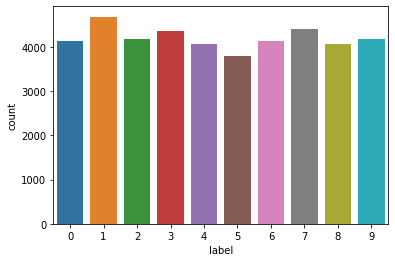

In [8]:
sns.countplot(df_y)
df_y.value_counts().sort_index()

In [39]:
#Split the dataset

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42, stratify=df_y)
print("Train data shape: ",X_train.shape)
print("Test data shape: ",X_test.shape)

Train data shape:  (29400, 784)
Test data shape:  (12600, 784)


## Functions used for classification and reporting their results

In [40]:
def accuracy_per_class(target_test, pred):
    matrix = confusion_matrix(target_test, pred)
    acc_per_class = matrix.diagonal()/matrix.sum(axis=1)
    acc_per_class_dict = {i:v for i,v in enumerate(acc_per_class)}
    return acc_per_class_dict
    

def classification_report_for_cv(target_test, pred):
    print ("Classification Report")
    print(classification_report(target_test, pred))
    return accuracy_score(target_test, pred)

def general_classification_report(target_test, pred):
    """
    General Classification Report
    :param target_test: target test data
    :param pred: the prediction of the classifier
    """
    print ("Classification Report")
    print(classification_report(target_test, pred))
    print("Accuracy per class")
    pprint(accuracy_per_class(target_test, pred))
    cmrforest = confusion_matrix(target_test , pred)
    plt.figure(figsize=(10,7))
    sns.heatmap(cmrforest ,annot=True , fmt = 'd')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.title('Confusion Report')


def perform_classification(clf_name, data_train, data_test, target_train, target_test):
    """
    Function that uses several classifiers
    :param clf_name: Classifier name, can be Random Forest, SVM rbf, SVM linear, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    """
    if clf_name=='Random Forest':
        clf=RandomForestClassifier(n_estimators=100)

    elif clf_name=='SVM rbf':
        clf = svm.SVC(kernel='rbf')

    elif clf_name=='kNN':
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    clf.fit(data_train, target_train)
    pred=clf.predict(data_test)
    general_classification_report(target_test, pred)


    
def perform_cross_validation(clf_name, X,y, feature_selection=None):
    """
    Function that performs 10-fold cross-vaidation using a given classifier
    :param clf_name: Classifier name, can be Random Forest, SVM rbf, SVM linear, kNN, Logistic Regression
    :param X: train data
    :param y: test data
    :param feature_selection: The feature selection/reduction method to use
    """
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=42)

    accuracy = 0
    precision = 0
    recall = 0
    f1 = 0
    X = X.to_numpy()
    y = y.to_numpy()
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        
        if feature_selection=='pca':
            fs = PCA(n_components=0.95).fit(X_train)
            X_train = fs.transform(X_train)
            X_test = fs.transform(X_test) 
        elif feature_selection=='selectKbest':
            fs = SelectKBest(score_func=chi2, k=200).fit(X_train, y_train)
            X_train = fs.transform(X_train)
            X_test = fs.transform(X_test)

        # X_train, X_test, y_train, y_test = train_test_split( feature_array, label_array, test_size = 0.3,stratify=label_array, random_state = 100)
        if clf_name=='Random Forest':
            clf=RandomForestClassifier(n_estimators=100)

        elif clf_name=='SVM rbf':
            clf = svm.SVC(kernel='rbf')

        elif clf_name=='kNN':
            clf = KNeighborsClassifier()

        elif clf_name=='Logistic Regression':
            clf = LogisticRegression()

        else:
            print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
            return
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)


        accuracy += accuracy_score(y_test, y_pred)*100
        precision += precision_score(y_test, y_pred,average='macro')*100
        recall += recall_score(y_test, y_pred, average='macro')*100
        f1 += f1_score(y_test, y_pred, average='macro')*100


    print("Average Accuracy:", accuracy/10)
    print("Macro-Average Precision:", precision/10)
    print("Macro-Average Recall:", recall/10)
    print("Macro-Average F1 score:", f1/10)

## Classifier tuning with grid search was implemented but not completed as it was computationally expensive (required too much time)

In [41]:
def perform_classification_with_grid_search(clf_name, data_train, data_test, target_train, target_test, cv=10):
    """
    Function that uses several classifiers with parameter tuning
    :param clf_name: Classifier name, can be Random Forest, SVM, kNN, Logistic Regression
    :param data_train: train data
    :param data_test: test data
    :param target_train: target train data
    :param target_test: target test data
    :param cv: number of folds
    :return: A dictionary with the best parameters
    """
    if clf_name=='Random Forest':
        param_grid = {
            'n_estimators': [200],
            'max_features': ['auto'],
            'max_depth' : [4,5,6,7,8],
            'criterion' :['gini', 'entropy']
        }
        clf = RandomForestClassifier(random_state=42)

    elif clf_name=='SVM':
        param_grid = {
            'kernel': ['rbf'],
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000]
            }
        clf = svm.SVC()

    elif clf_name=='kNN':
        param_grid = {'n_neighbors': range(1, 31)}
        clf = KNeighborsClassifier()

    elif clf_name=='Logistic Regression':
        param_grid = {"C": np.logspace(-3,3,7),
                      "penalty": ["l1","l2"]}
        clf = LogisticRegression()

    else:
        print('Provide one of the available classifiers: Random Forest, SVM, kNN, Logistic Regression')
        return

    cv_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv=cv)
    cv_rfc.fit(data_train, target_train)
     # Viewing The Best Parameters
    print('Best Parameters: ', cv_rfc.best_params_)
    print('Best Accuracy Score Achieved in Grid Search: ', cv_rfc.best_score_)
    best_estimator = cv_rfc.best_estimator_
    # Predicting using the best estimator
    best_estimator.fit(data_train, target_train)
    pred=best_estimator.predict(data_test)
    general_classification_report(target_test, pred)
    best_estimator.score(data_test, target_test)


## Classfication without feature selection/reduction

### Logistic Regression with holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1240
           1       0.95      0.98      0.96      1405
           2       0.90      0.89      0.89      1253
           3       0.89      0.89      0.89      1305
           4       0.92      0.92      0.92      1222
           5       0.88      0.83      0.85      1139
           6       0.93      0.96      0.95      1241
           7       0.93      0.92      0.93      1320
           8       0.85      0.85      0.85      1219
           9       0.87      0.89      0.88      1256

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600

Accuracy per class
{0: 0.9540322580645161,
 1: 0.9765124555160143,
 2: 0.8906624102154829,
 3: 0.8881226053639847,
 4: 0.9165302782324058,
 5: 0.8331870061457419,
 6: 0.9572925060435133,
 7: 0.921969696969697,
 8: 0.851

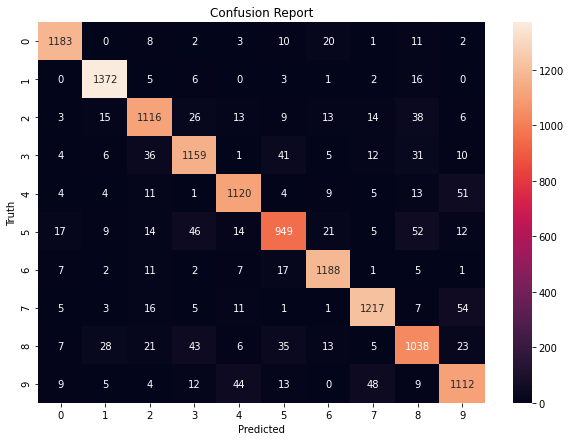

In [13]:
perform_classification('Logistic Regression', X_train, X_test, y_train, y_test)

### Logistic Regression with cross-validation evaluation

In [14]:
perform_cross_validation('Logistic Regression', df_x, df_y)

Average Accuracy: 91.4095238095238
Macro-Average Precision: 91.31879690168495
Macro-Average Recall: 91.27822317136376
Macro-Average F1 score: 91.28681232733332


### kNN with holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1240
           1       0.94      0.99      0.97      1405
           2       0.98      0.95      0.97      1253
           3       0.96      0.96      0.96      1305
           4       0.97      0.96      0.97      1222
           5       0.95      0.95      0.95      1139
           6       0.98      0.99      0.98      1241
           7       0.96      0.97      0.96      1320
           8       0.99      0.91      0.94      1219
           9       0.94      0.95      0.95      1256

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600

Accuracy per class
{0: 0.9919354838709677,
 1: 0.994306049822064,
 2: 0.9545091779728652,
 3: 0.9601532567049809,
 4: 0.9607201309328969,
 5: 0.9499561018437226,
 6: 0.9895245769540693,
 7: 0.9659090909090909,
 8: 0.906

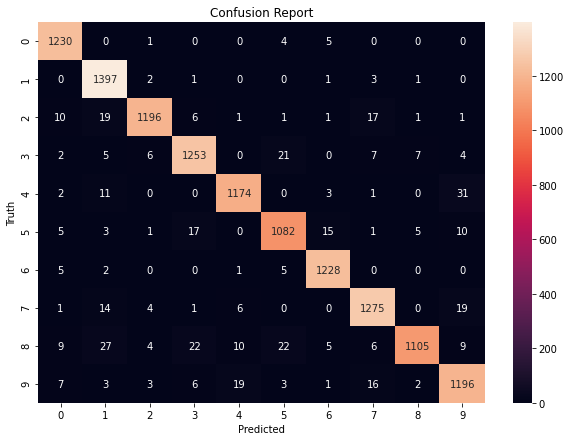

In [15]:
perform_classification('kNN', X_train, X_test, y_train, y_test)

### kNN with cross-validation evaluation 

In [16]:
perform_cross_validation('kNN', df_x, df_y)

Average Accuracy: 96.56031746031746
Macro-Average Precision: 96.62441309196176
Macro-Average Recall: 96.50449176248074
Macro-Average F1 score: 96.5401950979867


### SVM (RBF kernel) with holdout evaluation 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1240
           1       0.98      0.99      0.99      1405
           2       0.97      0.98      0.97      1253
           3       0.97      0.96      0.96      1305
           4       0.97      0.97      0.97      1222
           5       0.96      0.96      0.96      1139
           6       0.98      0.99      0.99      1241
           7       0.97      0.97      0.97      1320
           8       0.96      0.96      0.96      1219
           9       0.96      0.95      0.96      1256

    accuracy                           0.97     12600
   macro avg       0.97      0.97      0.97     12600
weighted avg       0.97      0.97      0.97     12600

Accuracy per class
{0: 0.9846774193548387,
 1: 0.9914590747330961,
 2: 0.9760574620909817,
 3: 0.9563218390804598,
 4: 0.9713584288052373,
 5: 0.9640035118525022,
 6: 0.9879129734085415,
 7: 0.9719696969696969,
 8: 0.96

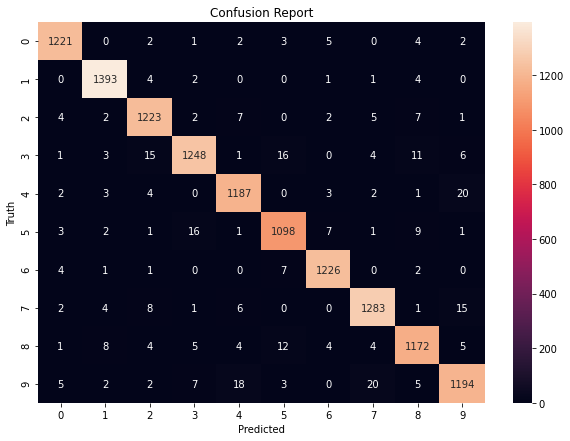

In [17]:
perform_classification('SVM rbf', X_train, X_test, y_train, y_test)

### SVM (RBF kernel) with cross-validation evaluation 

In [18]:
perform_cross_validation('SVM rbf', df_x, df_y)

Average Accuracy: 97.45
Macro-Average Precision: 97.43486532508427
Macro-Average Recall: 97.4357531557136
Macro-Average F1 score: 97.4338329190718


### Random Forest with holdout evaluation 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1240
           1       0.98      0.99      0.98      1405
           2       0.96      0.97      0.96      1253
           3       0.96      0.94      0.95      1305
           4       0.96      0.97      0.96      1222
           5       0.96      0.94      0.95      1139
           6       0.97      0.98      0.97      1241
           7       0.97      0.96      0.97      1320
           8       0.94      0.94      0.94      1219
           9       0.95      0.94      0.94      1256

    accuracy                           0.96     12600
   macro avg       0.96      0.96      0.96     12600
weighted avg       0.96      0.96      0.96     12600

Accuracy per class
{0: 0.9798387096774194,
 1: 0.9857651245551602,
 2: 0.9704708699122107,
 3: 0.9440613026819923,
 4: 0.9664484451718495,
 5: 0.9446883230904302,
 6: 0.9806607574536664,
 7: 0.9643939393939394,
 8: 0.94

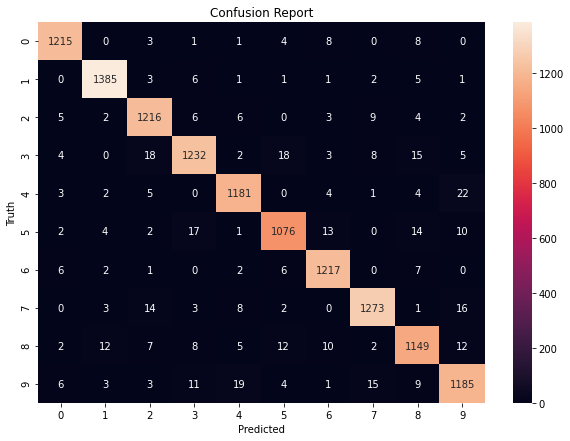

In [19]:
perform_classification('Random Forest', X_train, X_test, y_train, y_test)

### Random Forest with cross-validation evaluation 

In [20]:
perform_cross_validation('Random Forest', df_x, df_y)

Average Accuracy: 96.34841269841272
Macro-Average Precision: 96.32777757234831
Macro-Average Recall: 96.32494813140814
Macro-Average F1 score: 96.32381953794186


## Classification with PCA

#### Cross-validation evaluation couldn't be performed in combination with PCA as memory issues arised

### Transform data with PCA

In [43]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)

X_train_new = pca.transform(X_train)
X_test_new = pca.transform(X_test)
print("Train data shape: ", X_train_new.shape)
print("Test data shape: ",X_test_new.shape)

Train data shape:  (29400, 153)
Test data shape:  (12600, 153)


### Plot explained variance according to the number of components selected for PCA, to explain the number of components that was selected

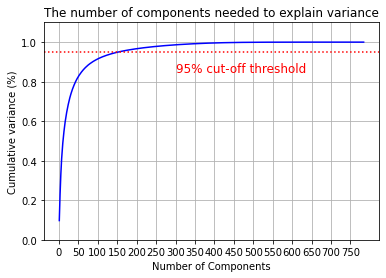

In [23]:
pca = PCA().fit(X_train)

fig, ax = plt.subplots()
xi = np.arange(1, 785, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 785, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='dotted')
plt.text(300, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)

ax.grid()
plt.show()

### Logistic Regression with PCA and holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1240
           1       0.92      0.97      0.95      1405
           2       0.91      0.90      0.91      1253
           3       0.91      0.88      0.89      1305
           4       0.90      0.92      0.91      1222
           5       0.88      0.84      0.86      1139
           6       0.93      0.96      0.94      1241
           7       0.92      0.93      0.93      1320
           8       0.89      0.83      0.86      1219
           9       0.89      0.88      0.88      1256

    accuracy                           0.91     12600
   macro avg       0.91      0.91      0.91     12600
weighted avg       0.91      0.91      0.91     12600

Accuracy per class
{0: 0.9580645161290322,
 1: 0.9743772241992883,
 2: 0.8994413407821229,
 3: 0.8796934865900383,
 4: 0.9230769230769231,
 5: 0.8446005267778753,
 6: 0.959709911361805,
 7: 0.9325757575757576,
 8: 0.833

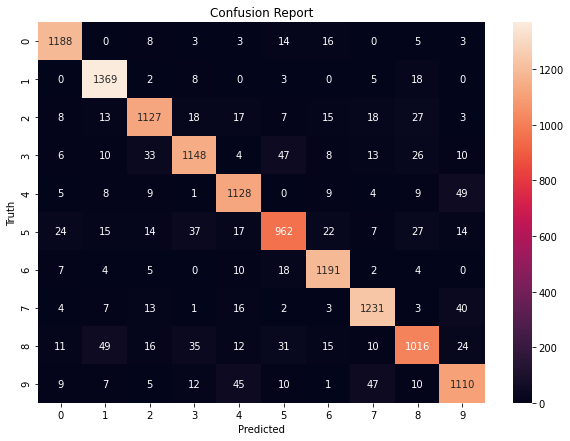

In [25]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

### kNN with PCA and holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1240
           1       0.95      0.99      0.97      1405
           2       0.98      0.96      0.97      1253
           3       0.96      0.96      0.96      1305
           4       0.97      0.97      0.97      1222
           5       0.95      0.95      0.95      1139
           6       0.97      0.99      0.98      1241
           7       0.97      0.97      0.97      1320
           8       0.99      0.92      0.95      1219
           9       0.95      0.95      0.95      1256

    accuracy                           0.97     12600
   macro avg       0.97      0.97      0.97     12600
weighted avg       0.97      0.97      0.97     12600

Accuracy per class
{0: 0.9919354838709677,
 1: 0.993594306049822,
 2: 0.9648842777334398,
 3: 0.9601532567049809,
 4: 0.9656301145662848,
 5: 0.9508340649692713,
 6: 0.9911361804995971,
 7: 0.9681818181818181,
 8: 0.917

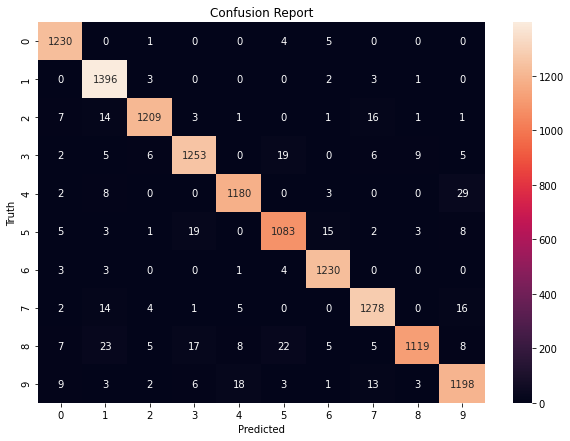

In [26]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

### SVM (RBF kernel) with PCA and holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1240
           1       0.99      0.99      0.99      1405
           2       0.97      0.98      0.98      1253
           3       0.98      0.96      0.97      1305
           4       0.97      0.98      0.97      1222
           5       0.97      0.97      0.97      1139
           6       0.99      0.99      0.99      1241
           7       0.98      0.98      0.98      1320
           8       0.97      0.97      0.97      1219
           9       0.97      0.96      0.96      1256

    accuracy                           0.98     12600
   macro avg       0.98      0.98      0.98     12600
weighted avg       0.98      0.98      0.98     12600

Accuracy per class
{0: 0.9862903225806452,
 1: 0.9921708185053381,
 2: 0.9840383080606544,
 3: 0.9632183908045977,
 4: 0.9754500818330606,
 5: 0.9701492537313433,
 6: 0.9911361804995971,
 7: 0.9757575757575757,
 8: 0.96

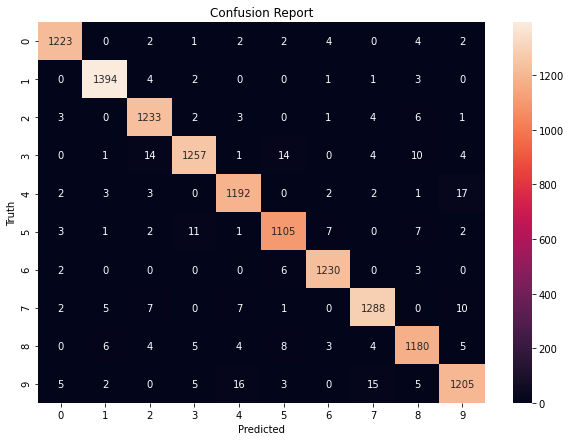

In [27]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

### Random Forest with PCA and holdout evaluation

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1240
           1       0.98      0.98      0.98      1405
           2       0.93      0.94      0.94      1253
           3       0.91      0.92      0.92      1305
           4       0.93      0.95      0.94      1222
           5       0.93      0.92      0.92      1139
           6       0.96      0.97      0.96      1241
           7       0.96      0.95      0.96      1320
           8       0.93      0.90      0.91      1219
           9       0.92      0.90      0.91      1256

    accuracy                           0.94     12600
   macro avg       0.94      0.94      0.94     12600
weighted avg       0.94      0.94      0.94     12600

Accuracy per class
{0: 0.978225806451613,
 1: 0.9793594306049822,
 2: 0.942537909018356,
 3: 0.9241379310344827,
 4: 0.9451718494271686,
 5: 0.9201053555750659,
 6: 0.9717969379532635,
 7: 0.9515151515151515,
 8: 0.8966

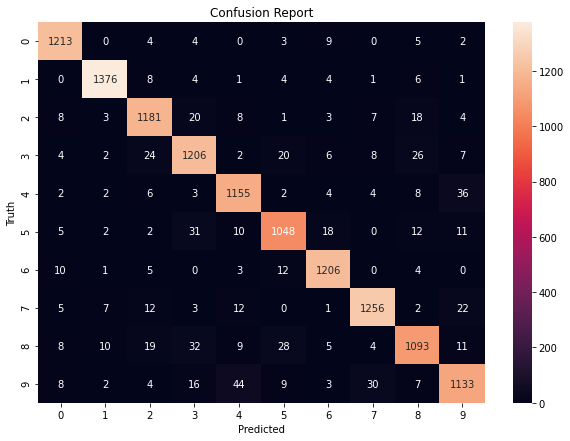

In [28]:
perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

## Classification with Feature Selection (SelectKBest)

## Feature Selection with the SelectKBest algorithm

In [30]:
best_features = SelectKBest(score_func=chi2, k=200)
fit = best_features.fit(X_train, y_train)
X_train_new = fit.transform(X_train)
X_test_new = fit.transform(X_test)

### Classification with Logistic Regression, holdout evaluation and Feature Selection (SelectKBest)

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      1240
           1       0.94      0.97      0.96      1405
           2       0.89      0.87      0.88      1253
           3       0.87      0.87      0.87      1305
           4       0.82      0.84      0.83      1222
           5       0.86      0.80      0.83      1139
           6       0.91      0.92      0.92      1241
           7       0.92      0.92      0.92      1320
           8       0.82      0.84      0.83      1219
           9       0.82      0.81      0.81      1256

    accuracy                           0.88     12600
   macro avg       0.88      0.88      0.88     12600
weighted avg       0.88      0.88      0.88     12600

Accuracy per class
{0: 0.9548387096774194,
 1: 0.9701067615658363,
 2: 0.8675179569034318,
 3: 0.8697318007662835,
 4: 0.839607201309329,
 5: 0.8033362598770851,
 6: 0.9226430298146656,
 7: 0.9204545454545454,
 8: 0.841

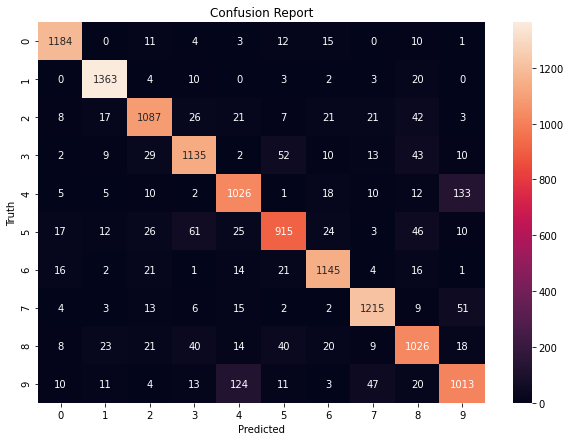

In [31]:
perform_classification('Logistic Regression', X_train_new, X_test_new, y_train, y_test)

### Classification with Logistic Regression, cross-validation evaluation and Feature Selection (SelectKBest)

In [32]:
perform_cross_validation('Logistic Regression', df_x, df_y,'selectKbest')

Average Accuracy: 88.27857142857142
Macro-Average Precision: 88.13220014192026
Macro-Average Recall: 88.09409447964407
Macro-Average F1 score: 88.09670442744711


### Classification with kNN, holdout evaluation and Feature Selection (SelectKBest)

Classification Report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1240
           1       0.94      0.99      0.97      1405
           2       0.97      0.94      0.96      1253
           3       0.93      0.94      0.93      1305
           4       0.88      0.84      0.86      1222
           5       0.93      0.88      0.91      1139
           6       0.97      0.97      0.97      1241
           7       0.94      0.97      0.96      1320
           8       0.98      0.90      0.94      1219
           9       0.84      0.90      0.87      1256

    accuracy                           0.93     12600
   macro avg       0.94      0.93      0.93     12600
weighted avg       0.94      0.93      0.93     12600

Accuracy per class
{0: 0.9879032258064516,
 1: 0.993594306049822,
 2: 0.9409417398244214,
 3: 0.9363984674329502,
 4: 0.8404255319148937,
 5: 0.884108867427568,
 6: 0.9717969379532635,
 7: 0.9696969696969697,
 8: 0.9007

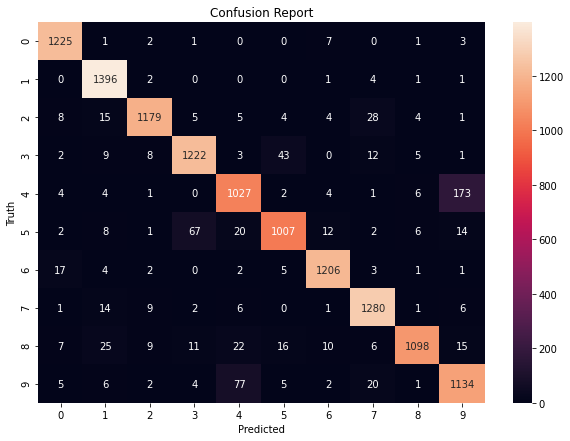

In [33]:
perform_classification('kNN', X_train_new, X_test_new, y_train, y_test)

### Classification with kNN, cross-validation evaluation and Feature Selection (SelectKBest)

In [34]:
perform_cross_validation('kNN', df_x, df_y,'selectKbest')

Average Accuracy: 93.5095238095238
Macro-Average Precision: 93.60111622669885
Macro-Average Recall: 93.37392717442174
Macro-Average F1 score: 93.43022650778572


### Classification with SVM (RBF kernel), holdout evaluation and Feature Selection (SelectKBest)

Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1240
           1       0.98      0.99      0.98      1405
           2       0.96      0.97      0.96      1253
           3       0.95      0.95      0.95      1305
           4       0.93      0.90      0.92      1222
           5       0.94      0.93      0.94      1139
           6       0.97      0.98      0.98      1241
           7       0.96      0.97      0.96      1320
           8       0.96      0.95      0.96      1219
           9       0.91      0.92      0.92      1256

    accuracy                           0.96     12600
   macro avg       0.96      0.95      0.95     12600
weighted avg       0.96      0.96      0.96     12600

Accuracy per class
{0: 0.9846774193548387,
 1: 0.9871886120996441,
 2: 0.9664804469273743,
 3: 0.9517241379310345,
 4: 0.9042553191489362,
 5: 0.9306409130816505,
 6: 0.9814665592264303,
 7: 0.9651515151515152,
 8: 0.95

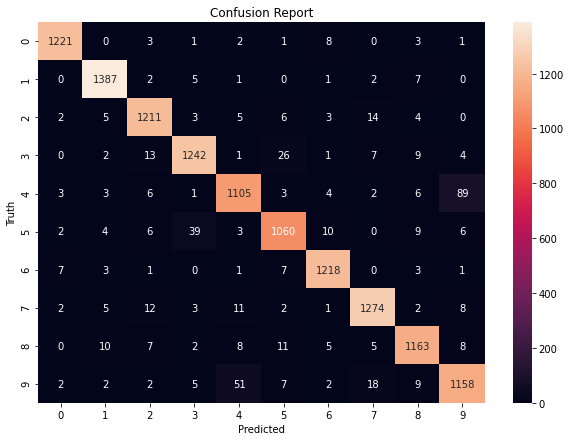

In [35]:
perform_classification('SVM rbf', X_train_new, X_test_new, y_train, y_test)

### Classification with SVM (RBF kernel), cross-validation evaluation and Feature Selection (SelectKBest)

In [36]:
perform_cross_validation('SVM rbf', df_x, df_y,'selectKbest')

Average Accuracy: 95.80873015873017
Macro-Average Precision: 95.7778953888818
Macro-Average Recall: 95.76532474997825
Macro-Average F1 score: 95.76651950690697


### Classification with Random Forest, holdout evaluation and Feature Selection (SelectKBest)

Classification Report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1240
           1       0.98      0.98      0.98      1405
           2       0.95      0.96      0.95      1253
           3       0.93      0.92      0.93      1305
           4       0.90      0.88      0.89      1222
           5       0.92      0.90      0.91      1139
           6       0.94      0.98      0.96      1241
           7       0.96      0.96      0.96      1320
           8       0.93      0.93      0.93      1219
           9       0.88      0.88      0.88      1256

    accuracy                           0.94     12600
   macro avg       0.94      0.94      0.94     12600
weighted avg       0.94      0.94      0.94     12600

Accuracy per class
{0: 0.978225806451613,
 1: 0.9829181494661922,
 2: 0.9561053471667997,
 3: 0.9172413793103448,
 4: 0.8821603927986906,
 5: 0.8999122036874452,
 6: 0.975825946817083,
 7: 0.9575757575757575,
 8: 0.9310

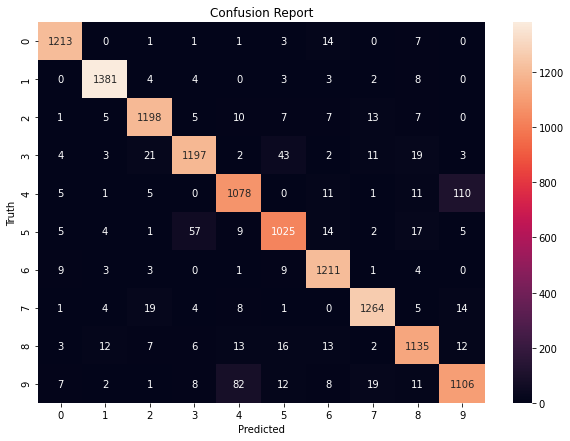

In [37]:
perform_classification('Random Forest', X_train_new, X_test_new, y_train, y_test)

### Classification with Random Forest, cross-validation evaluation and Feature Selection (SelectKBest)

In [38]:
perform_cross_validation('Random Forest', df_x, df_y,'selectKbest')

Average Accuracy: 94.04206349206348
Macro-Average Precision: 93.97072496935881
Macro-Average Recall: 93.97598339111934
Macro-Average F1 score: 93.96631406743782
